In [1]:
import collections
from noisyopt import minimizeSPSA
import pennylane as qml
from pennylane import numpy as np
import random
import seaborn as sns
import torch
from torch.autograd import Variable
# set the random seed
seed = 145
np.random.seed(seed)

# Data
We grab the adhoc data from qiskit and will try and replicate the results as impelmented in  <a href="https://arxiv.org/pdf/1804.11326.pdf" class="external">Havlicek et al</a>.

/Users/rickyyoung/opt/anaconda3/envs/qBraid/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/Users/rickyyoung/opt/anaconda3/envs/qBraid/lib/python3.8/site-packages/qiskit/ml/__init__.py:40: DeprecationWarning: The package qiskit.ml is deprecated. It was moved/refactored to qiskit_machine_learning (pip install qiskit-machine-learning). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('ml', 'qiskit_machine_learning', 'qiskit-machine-learning')
/Users/rickyyoung/opt/anaconda3/envs/qBraid/lib/python3.8/site-packages/qiskit/ml/datasets/ad_hoc.py:79: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.algorithm_globals (pip

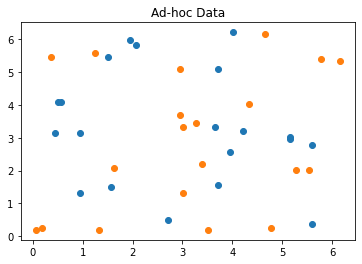

['A', 'B']
{'A': array([[3.64424748, 3.33008821],
       [0.43982297, 3.14159265],
       [2.70176968, 0.50265482],
       [5.15221195, 2.95309709],
       [0.56548668, 4.08407045],
       [5.59203492, 2.76460154],
       [3.70707933, 5.0893801 ],
       [0.9424778 , 1.31946891],
       [0.50265482, 4.08407045],
       [0.9424778 , 3.14159265],
       [3.95840674, 2.57610598],
       [4.0212386 , 6.22035345],
       [3.70707933, 1.57079633],
       [1.50796447, 5.46637122],
       [4.20973416, 3.20442451],
       [5.15221195, 3.01592895],
       [5.59203492, 0.37699112],
       [1.94778745, 5.96902604],
       [2.07345115, 5.84336234],
       [1.57079633, 1.50796447]]), 'B': array([[3.01592895, 1.31946891],
       [3.39292007, 2.19911486],
       [4.64955713, 6.1575216 ],
       [6.1575216 , 5.34070751],
       [3.51858377, 0.18849556],
       [1.31946891, 0.18849556],
       [0.18849556, 0.25132741],
       [5.52920307, 2.0106193 ],
       [3.01592895, 3.33008821],
       [1.25663706,

In [2]:
from qiskit.ml.datasets import ad_hoc_data, sample_ad_hoc_data
from qiskit.aqua.utils import split_dataset_to_data_and_labels
num_wires = 2
sample_total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=20, 
    test_size=10, 
    n=num_wires, 
    gap=0.3, 
    plot_data=True
)
extra_test_data = sample_ad_hoc_data(sample_total, 10, n=num_wires)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
print(class_labels)
print(training_input)

We shuffle the dataset after one hot encoding the data points.

In [3]:
def shuffled_data(data) -> list:
    shuffled_data = []
    for _, (k, v) in enumerate(data.items()):
        if isinstance(v,collections.Iterable):
            for val in v:
                shuffled_data.append((class_to_label[k],val))
    random.shuffle(shuffled_data)
    return shuffled_data
training_input_shuffled = shuffled_data(training_input)
test_input_shuffled = shuffled_data(test_input)

<ipython-input-3-32dfad1bdbdc>:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if isinstance(v,collections.Iterable):


We convert the data using a ZZFeature map. We consider the unitary to be an enta

In [33]:
def ZZFeatureMap(data_vector,num_wires) -> None:
    #if len(data_vector) != num_wires:
        #raise ValueError(f"data vector of size {len(data_vector)} is not compatible with feature dim of {num_wires}.")
    for i in range(num_wires):
        qml.Hadamard(wires=i)
        # our encoding of x_i for classical data X
        phi = 2.0*data_vector[i]
        qml.RZ(phi, wires=i)
    for i in range(num_wires-1):
        qml.CNOT(wires=[i,i+1])
        # our encoding of x_i for classical data X
        phi = 2.0*(np.pi-data_vector[i])*(np.pi-data_vector[i+1])
        qml.RZ(phi, wires=i+1)
        qml.CNOT(wires=[i,i+1]) 


In [34]:

num_wires = 4

num_qubits  = 4
dev_kernel = qml.device("default.qubit", wires=num_wires)


def QSVM(params,input_data=None):
    ZZFeatureMap(input_data[1],num_wires)  
    if train:
        qml.templates.BasicEntanglerLayers(params._value, wires=list(range(num_wires)))
    else:
        qml.templates.BasicEntanglerLayers(params, wires=list(range(num_wires)))
    measurements = qml.operation.Tensor(*[qml.PauliZ(qubit) for qubit in range(num_wires)])
    return qml.expval(measurements)

         

In [38]:
#
# finish optimization algorithm we run it through the Gradient Descent
num_layers=2
num_wires = 2

init_params = qml.init.basic_entangler_layers_normal(
    n_wires=num_wires, n_layers=num_layers
)


opt = qml.GradientDescentOptimizer(stepsize=0.3)
# Create a device, qnode and cost function specific to gradient descent
dev_sampler_gd = qml.device("qiskit.aer", wires=10, shots=1000)
qnode_gd = qml.QNode(QSVM, dev_sampler_gd)

drawer = qml.draw(qnode_gd)
print(drawer(params,[1,[3.26725636, 3.45575192]]))
def cost_gd(params,input_data):
    return (qnode_gd(params,input_data)-input_data[0])**2

steps = 20
params = init_params.copy()




 0: ──H──RZ(6.53)──╭C─────────────╭C──RX(0.0172)──╭C──RX(0.172)──╭C──╭┤ ⟨Z ⊗ Z⟩ 
 1: ──H──RZ(6.91)──╰X──RZ(0.079)──╰X──RX(0.103)───╰X──RX(0.328)──╰X──╰┤ ⟨Z ⊗ Z⟩ 



In [15]:
opt = qml.GradientDescentOptimizer(stepsize=0.3)

# Create a device, qnode and cost function specific to gradient descent
dev_sampler_gd = qml.device("qiskit.aer", wires=num_wires, shots=1000)
qnode_gd = qml.QNode(QSVM, dev_sampler_gd)


steps = 20
params = init_params.copy()
device_execs_grad = [0]
cost_store_grad = []
b = np.random.random()
# Set the number of training epochs
epochs = 5

cost_list =[]
target_list = []

for k in range(len(training_input_shuffled)):
    train = True
    params,val = opt.step_and_cost(lambda params: cost_gd(params,input_data=training_input_shuffled[k]), params)
    device_execs_grad.append(dev_sampler_gd.num_executions)
    cost_store_grad.append(val)
    print(
        f"Iteration = {k}, "
        f"Number of device executions = {dev_sampler_gd.num_executions}, "
        f"Cost = {val}"
    )
    print("val",val)
    if val < 0.50:
        cost_list.append(0)
    else:
        cost_list.append(1)  
    target_list.append( training_input_shuffled[k][0])
    
def accuracy_score(pred,target):
    score = np.array(pred) == np.array(target)
    return float(score.sum()/len(target))

accuracy_score(cost_list,target_list)

Iteration = 0, Number of device executions = 1, Cost = 1.065024
val 1.065024
Iteration = 1, Number of device executions = 2, Cost = 0.933156
val 0.933156
Iteration = 2, Number of device executions = 3, Cost = 1.0857640000000002
val 1.0857640000000002
Iteration = 3, Number of device executions = 4, Cost = 1.1491840000000002
val 1.1491840000000002
Iteration = 4, Number of device executions = 5, Cost = 0.001024
val 0.001024
Iteration = 5, Number of device executions = 6, Cost = 0.0009
val 0.0009
Iteration = 6, Number of device executions = 7, Cost = 0.8537760000000001
val 0.8537760000000001
Iteration = 7, Number of device executions = 8, Cost = 0.753424
val 0.753424
Iteration = 8, Number of device executions = 9, Cost = 0.0036
val 0.0036
Iteration = 9, Number of device executions = 10, Cost = 0.001444
val 0.001444
Iteration = 10, Number of device executions = 11, Cost = 0.8537760000000001
val 0.8537760000000001
Iteration = 11, Number of device executions = 12, Cost = 0.012996
val 0.012996

1.0

To test our model we will use the same parameter and train it on the test set.

In [8]:
# evaluate

train = False
check = 0
for val in test_input_shuffled:
    print(val)
    x = qnode_gd(params,input_data=val)
    print(x)
    if x>0.5:
        if 1==val[0]:
            check += 1
    else:
        if 0==val[0]:
            check += 1
    
print(check/len(test_input_shuffled))

(1, array([0.06283185, 1.82212374]))
-0.132
(0, array([2.82743339, 0.56548668]))
0.012
(1, array([3.39292007, 0.62831853]))
-0.03
(1, array([4.77522083, 5.65486678]))
0.112
(1, array([1.13097336, 0.69115038]))
-0.044
(1, array([3.33008821, 2.0106193 ]))
0.094
(0, array([0.69115038, 2.19911486]))
0.102
(1, array([5.0893801 , 1.69646003]))
0.016
(0, array([4.27256601, 2.51327412]))
-0.118
(1, array([2.63893783, 5.46637122]))
0.066
(0, array([4.33539786, 2.63893783]))
-0.094
(0, array([2.07345115, 1.00530965]))
0.04
(1, array([2.95309709, 1.88495559]))
-0.136
(1, array([3.0787608 , 0.81681409]))
-0.092
(1, array([4.0212386 , 0.56548668]))
0.028
(0, array([5.27787566, 5.65486678]))
-0.142
(0, array([0.69115038, 1.63362818]))
-0.114
(0, array([0.        , 1.57079633]))
0.066
(0, array([0.25132741, 4.64955713]))
0.058
(0, array([5.27787566, 3.45575192]))
0.088
0.5


In [ ]:
sns